# Lab 06: Group By, Pivot Tables, and Data Cubes

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
titanic_df = pd.read_csv("./data/titanic.csv")

In the previous section, we discussed how to restrict our analysis to a particular subset of observations using boolean masks. So, for example, if we wanted to calculate the survival rate for passengers in third class, we would write:

In [7]:
titanic_df[titanic_df.pclass == 3].survived.mean()

0.2552891396332863

But what if we wanted to calculate the survival rate by class? We could slice the data set three times, once for each class:

In [8]:
(titanic_df[titanic_df.pclass == 1]['survived'].mean(), 
 titanic_df[titanic_df.pclass == 2]['survived'].mean(), 
 titanic_df[titanic_df.pclass == 3]['survived'].mean())

(0.6191950464396285, 0.4296028880866426, 0.2552891396332863)

But this code is inefficient and repetitive. It also does not generalize well to variables with hundreds of possible categories. 

The problem of calculating the survival rate by class is an example of a problem that can be solved using the **split-apply-combine strategy**. The key insight here is that many data analyses follow the same basic pattern:

- First, a data set is **split** into several subsets based on some variable.
- Next, some analysis is **applied** to each subset.
- Finally, the results from each analysis are **combined**.

The three steps are diagrammed in the figure below:

![](./images/split_apply_combine.png) [source](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb)

Applying this strategy to our working example above, we should first _split_ up the Titanic data according to the value of `pclass`, _apply_ `.survived.mean()` to each subset, and finally _combine_ the results into one `Series`.

[_Note:_ The term "split-apply-combine" was coined by Hadley Wickham in [a 2011 paper](https://www.jstatsoft.org/article/view/v040i01), but the idea is not new. It should already be familiar to you if you know SQL or MapReduce.]

## Split-Apply-Combine in `pandas`: the `.groupby()` method

To implement the split-apply-combine strategy in `pandas`, we use the `.groupby()` method. First, we specify one or more variables to split on in the argument to `.groupby()`. Then, we specify our analysis as usual. Pandas will handle splitting the data, applying the analysis to each subset, and combining the results at the end.

In [9]:
titanic_df.groupby("pclass").survived.mean()

pclass
1    0.619195
2    0.429603
3    0.255289
Name: survived, dtype: float64

Compare this line of code with the code to calculate the overall survival rate:

`titanic_df.survived.mean()`.

The only difference is `.groupby("pclass")`. This turns a `DataFrame` into a `DataFrameGroupBy` object, which behaves like a `DataFrame`, except that any analysis that we specify will be applied to subsets of the `DataFrame` instead of the whole `DataFrame`.

You can even make visualizations with `.groupby()`! To plot the age distribution of the survivors and non-survivors, we can group by the `survived` variable and then ask for a histogram of `age`. Behind the scenes, `pandas` will do this once for the survivors and again for the non-survivors and then combine them into one histogram.

survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

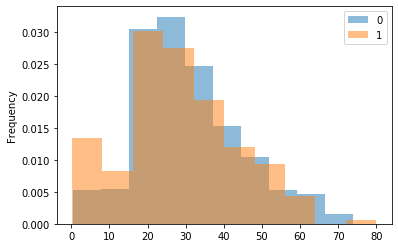

In [10]:
titanic_df.groupby("survived").age.plot.hist(alpha=.5, density=True, legend=True)

It is also possible to group by more than one variable. Simply pass in a list of variable names to `.groupby()`. For example, the following code calculates the survival rate by class and sex:

In [11]:
survival_rates = titanic_df.groupby(["pclass", "sex"])["survived"].mean()
survival_rates

pclass  sex   
1       female    0.965278
        male      0.340782
2       female    0.886792
        male      0.146199
3       female    0.490741
        male      0.152130
Name: survived, dtype: float64

It's clear that survival rates on the Titanic varied drastically by class and by sex.

Notice that when we use `.groupby()`, the resulting index is whatever variable(s) we grouped by. Since we grouped by two variables, this index actually has two levels. An index with more than one level is called a `MultiIndex` in `pandas`. To access a particular row in a `DataFrame` that is indexed by a `MultiIndex`, we pass in a tuple of the values we want from each level.

So, for example, to get female passengers in 2nd class, we would do:

In [ ]:
survival_rates.loc[(2, "female")]

If we pass in fewer values than there are levels in the index, `pandas` will return everything from the remaining levels.

In [ ]:
survival_rates.loc[2]

In [ ]:
survival_rates.loc[:, 'female']

Note that some times the above won't work depending on how the indicies are setup.  It may be eaiser to use the [.xs method sometimes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html).

In [ ]:
survival_rates.xs('female', level=1)

## Pivot Tables and The Data Cube

In [ ]:
titanic_df["adult"] = (titanic_df["age"] >= 18)

In Section 2.2, we learned to split a `pandas` `DataFrame` and apply the same analysis to each of the resulting, smaller `DataFrame`s. For example, the following code calculates the proportion of Titanic passengers of each sex, age group, and class who survived:

In [ ]:
survivors_table = (titanic_df.
                   groupby(["sex", "adult", "pclass"]).
                   survived.
                   mean())
survivors_table.to_frame()

Here's another way to think about these results: there are three dimensions, `sex`, `adult`, and `pclass`, and we calculate a metric, the proportion of survivors, for each of the $2 \times 2 \times 3 = 12$ possible combinations of the dimension values.

There are many equivalent ways to represent these results. The representation above is essentially the _tabular form_ that we learned in Chapter 1. Each row represents an observation (i.e., a distinct combination of sex, adult, and class) and each column a variable (i.e., the proportion of passengers who survived). Another way to represent these results is using a **data cube**. In a data cube, the possible values of each dimension are laid out along one dimension of a cube, as shown below:

![](./images/datacube.png)

The term "data _cube_" is somewhat of a misnomer, since it does not have to be a cube. First, as we can plainly see in the figure above, the dimensions need not all be the same size; some dimensions may have more values than others. Second, a data cube can have any number of dimensions, so it does not have to be three-dimensional. A data cube with $d$ dimensions is really a $d$-dimensional hypercube. A 2-dimensional hypercube is a square (or rectangle), a 1-dimensional hypercube is a line, and a 0-dimensional hypercube is a point.

While it is useful to imagine a data cube as a $d$-dimensional hypercube, it is not practical to display data in a hypercube---at least not when $d > 2$. So a data cube is often printed as a two-dimensional table, with multi-level row indexes and columns to represent the dimensions. This two-dimensional representation of the data cube is called a **pivot table**. Here is the code to produce a pivot table from the raw data:

In [ ]:
survivors_cube = titanic_df.pivot_table(
    index="sex", columns=["adult", "pclass"],
    values="survived", aggfunc=np.mean)
survivors_cube

To create a pivot table, we had to specify 
- the row index(es): Here, we chose to include two of the dimensions (`adult`, `sex`) along the rows of the pivot table.
- the column(s): Here, we chose to include the one remaining dimension (`pclass`) in the columns.
- the metric in the cells of the table: Here, we chose to report the _mean_ of the `survived` column in each cell.

The resulting pivot table is just stored in an ordinary `DataFrame`; `pandas` does not have a special data structure for pivot tables.

Notice how we explicitly specified an aggregation function `aggfunc`. That's because in the original `DataFrame` (`titanic_df`), there were many passengers with the same values for all three dimensions, so each cell of this pivot table actually represents many passengers. In order to summarize all of these passengers by a single value, we have to aggregate the values. The mean is not the only aggregation function we could have used; we could have also calculated the sum, to obtain the _number_ of survivors.

In [ ]:
titanic_df.pivot_table(
    index="sex", columns=["adult", "pclass"],
    values="survived", aggfunc=np.sum
)

If the data is in data cube form (i.e., in a pivot table), it can be converted to tabular form by simply stacking the columns, one on top of the other. In `pandas`, this can be done using the `.stack()` function:

In [ ]:
survivors_cube.stack(["adult", "pclass"])

Compare the above result with `survivors_table`.

Likewise, we can convert a `pandas` object in tabular form to data cube form by _unstacking_ the index, assuming that all of the dimensions are already in the index.

In [ ]:
survivors_cube = survivors_table.unstack(["adult", "pclass"])
survivors_cube

Stacking tends to produce longer objects with more rows, while unstacking tends to produce wider objects with more columns. For this reason, tabular form is sometimes referred to as "long form", in contrast to the data cube, which is "wide form."

# Some Features of Data Cubes

It is much easier to quickly compare numbers in data cube form than in tabular form. For example, it is apparent from the preceding pivot table that males had much lower survival rates than females just by comparing the numbers across each row; this fact is more difficult to discern from `survivors_table`.

It is also more efficient to store data in a data cube. Recall that `survivors_table` and `survivors_cube` contain the exact same information. However, the data cube is 70% smaller than the tabular version of the same data:

In [ ]:
survivors_table.__sizeof__(), survivors_cube.__sizeof__()

In many implementations of the data cube, it is also faster to access values in a data cube than in a table. Unfortunately, because `pandas` represents data cubes as two-dimensional pivot tables, it does not enjoy these advantages.

In [ ]:
survivors_table.loc["female", True, 1]

In [ ]:
survivors_cube.loc["female", (True, 1)]

Data cubes also play nicely with bar charts in `pandas`. When `.plot.bar()` is called on a `pandas` `DataFrame`, one set of bars will be created for each column. So when we call `.plot.bar()` on a pivot table, we will get one set of bars for females and another set of bars for males.

In [ ]:
survivors_cube.plot.bar()

Notice that the $x$-axis of the bar graph contains all of the dimensions in the row index. So to get `pclass` on the $x$-axis, we have to create a pivot table where `pclass` is the row index:

In [ ]:
titanic_df.pivot_table(
    index="pclass", columns=["adult", "sex"],
    values="survived", aggfunc=np.mean
).plot.bar()

Finally, many analytical operations are easier to do when the data is in data cube format.

# Exercises

Exercises 1-2 deal with the Tips data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv`).

In [ ]:
tips_df = pd.read_csv("./data/tips.csv")
tips_df["tip_percent"] = tips_df.tip / tips_df.total_bill
tips_df.head()

**Exercise 1.** On which day of the week does the waiter serve the largest parties, on average? (You did this exercise in the previous section. See how much easier it is to do using `.groupby()`.)

In [72]:
# YOUR CODE HERE

**Exercise 2.** Calculate the average bill by day and time. What day-time combination has the highest average bill?

In [71]:
# YOUR CODE HERE

**Answer Here:**

**Exercise 3.** Extract the average bill for Friday lunch from the result of Exercise 2.

In [ ]:
# YOUR CODE HERE

**Exercise 4.** Use `.groupby()` to make a visualization comparing the distribution of tip percentages left by males and females. How do they compare?

In [ ]:
# YOUR CODE HERE

**Exercise 5.** Calculate the average total bill by day, time, and table size. Display the results in a pivot table.

In [ ]:
# TYPE YOUR CODE HERE.

**Exercise 6.** Make a bar chart showing the average total bill by table size, day, and time. (You will have to decide which variable(s) to represent on the $x$-axis and which variable(s) to represent using different colored bars.)  Explain your choice below.

In [ ]:
# TYPE YOUR CODE HERE.

**Answer Here:**

Exercises 3-4 deal with the Ames Housing data set (`./data/ames.tsv`). For more information about the variables in this data set, please refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [ ]:
df_ames = pd.read_csv("./data/ames.tsv", sep='\t')
display(df_ames.head())

**Exercise 7.** Calculate the average house price by neighborhood and building type, and store it in data cube form. Use the data cube to determine the neighborhood with the most expensive single-family homes.

In [ ]:
# TYPE YOUR CODE HERE.

**Answer Here:**

**Exercise 8.** In the data cube above, there were many NaN values. Why is that? How is this a potential downside of the data cube format?

**TYPE YOUR EXPLANATION HERE.**

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)